<a href="https://colab.research.google.com/github/GauravKrGuptaDS/Car-Sales-Price-Prediction/blob/main/ANN_Car_Sales_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1 : Install and Import Required Libraries

In [59]:
# Install required packages
!pip install scikit-learn pandas numpy matplotlib seaborn tensorflow -q

print("✓ All packages installed successfully!")

✓ All packages installed successfully!


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {keras.__version__}")

✓ All libraries imported successfully!
TensorFlow version: 3.10.0


## Step 2 : Loading the data

In [7]:
# Loading the data
df = pd.read_csv("/content/car_purchasing.csv",encoding='ISO-8859-1')
df.head()

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


In [8]:
df = df.drop(columns=["customer name", "customer e-mail"])

#df.drop()

In [9]:
# Basic statistics
print("\nBasic Statistics:")
df.describe()


Basic Statistics:


,gender,age,annual Salary,credit card debt,net worth,car purchase amount
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.506000,46.241674,62127.239608,9607.645049,431475.713625,44209.799218
std,0.500465,7.978862,11703.378228,3489.187973,173536.756340,10773.178744
min,0.000000,20.000000,20000.000000,100.000000,20000.000000,9000.000000
25%,0.000000,40.949969,54391.977195,7397.515792,299824.195900,37629.896040
50%,1.000000,46.049901,62915.497035,9655.035568,426750.120650,43997.783390
75%,1.000000,51.612263,70117.862005,11798.867487,557324.478725,51254.709517
max,1.000000,70.000000,100000.000000,20000.000000,1000000.000000,80000.000000


## Step 3 : Feature Engineering

In [10]:
# Avoid division by zero
epsilon = 1e-5

df["debt_to_income"] = df["credit card debt"] / (df["annual Salary"] + epsilon)
df["networth_to_income"] = df["net worth"] / (df["annual Salary"] + epsilon)
df["disposable_income"] = df["annual Salary"] - df["credit card debt"]

df["age_squared"] = df["age"] ** 2
df["salary_x_age"] = df["annual Salary"] * df["age"]


In [11]:
df["age_group"] = pd.cut(
    df["age"],
    bins=[18, 25, 35, 45, 60, 100],
    labels=["18-25", "26-35", "36-45", "46-60", "60+"]
)


In [12]:
df["premium_customer"] = np.where(
    (df["annual Salary"] > df["annual Salary"].median()) &
    (df["net worth"] > df["net worth"].median()) &
    (df["credit card debt"] < df["credit card debt"].median()),
    1, 0
)


In [13]:
df["log_salary"] = np.log1p(df["annual Salary"])
df["log_net_worth"] = np.log1p(df["net worth"])
df["log_debt"] = np.log1p(df["credit card debt"])


In [14]:
X = df.drop(columns=["car purchase amount"])
y = df["car purchase amount"] # Target column

## Step 4 : Data Preparation and Training

In [15]:
numerical_features = [
    "age",
    "age_squared",
    "annual Salary",
    "credit card debt",
    "net worth",
    "debt_to_income",
    "networth_to_income",
    "disposable_income",
    "salary_x_age",
    "log_salary",
    "log_net_worth",
    "log_debt"
]

categorical_features = [
    "gender",
    "country",
    "age_group"
]


In [16]:
#Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [17]:
X.columns

Index(['country', 'gender', 'age', 'annual Salary', 'credit card debt',
       'net worth', 'debt_to_income', 'networth_to_income',
       'disposable_income', 'age_squared', 'salary_x_age', 'age_group',
       'premium_customer', 'log_salary', 'log_net_worth', 'log_debt'],
      dtype='object')

In [18]:
# Split data: 80% training, 20% testing
# Important: shuffle=False to maintain time series order ---Not Required in this
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = 42
)

print("\nData Split:")
print(f"  Training samples: {X_train.shape[0]} ({(X_train.shape[0]/X.shape[0])*100:.1f}%)")
print(f"  Testing samples: {X_test.shape[0]} ({(X_test.shape[0]/X.shape[0])*100:.1f}%)")


Data Split:
  Training samples: 400 (80.0%)
  Testing samples: 100 (20.0%)


In [20]:
#X_processed = preprocessor.fit_transform(X)

# Fit on training data and transform both train and test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#y_train_scaled = preprocessor.transform(y_train.reshape(-1, 1))
#y_test_scaled = preprocessor.transform(y_test)

print("✓ Features normalized")
print(f"  X_train_scaled range: [{X_train_processed.min():.4f}, {X_train_processed.max():.4f}]")
print(f"  y_train range: [{y_train.min():.4f}, {y_train.max():.4f}]")

input_dim = X_train_processed.shape[1]
print("Total input features after encoding:", input_dim)

✓ Features normalized
  X_train_scaled range: [-8.2818, 7.7306]
  y_train range: [9000.0000, 80000.0000]
Total input features after encoding: 213


## Step 5 : Build Artificial Neural Network (ANN) Model

In [21]:
#X_train_scaled.columns

print(np.isnan(X_train_processed.toarray()).sum())

0


In [22]:
# Build ANN architecture
print("Building Neural Network Architecture...\n")

model = Sequential([
    # Input Layer + First Hidden Layer
    Dense(64, activation='relu', input_shape=(input_dim,), name='Input_Layer'),
    Dropout(0.3, name='Dropout_1'),

    # Second Hidden Layer
    #Dense(64, activation='relu', name='Hidden_Layer_1'),
    #Dropout(0.2, name='Dropout_2'),

    # Second Hidden Layer
    Dense(32, activation='relu', name='Hidden_Layer_1'),
    Dropout(0.2, name='Dropout_2'),

    # Third Hidden Layer
    Dense(16, activation='relu', name='Hidden_Layer_2'),

    # Output Layer (Regression)
    Dense(1, name='Output_Layer')
])

print("✓ Model architecture created!")
print("\nModel Summary:")
model.summary()

Building Neural Network Architecture...

✓ Model architecture created!

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (Dense)             │ (None, 64)             │        13,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_1 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,321 (63.75 KB)

 Trainable params: 16,321 (63.75 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae']  # Mean Absolute Error
)

print("✓ Model compiled successfully!")
print("  Optimizer: Adam")
print("  Loss Function: Mean Squared Error (MSE)")
print("  Metrics: Mean Absolute Error (MAE)")

✓ Model compiled successfully!
  Optimizer: Adam
  Loss Function: Mean Squared Error (MSE)
  Metrics: Mean Absolute Error (MAE)


## Step 6 : Train the Model

In [24]:
# Setup callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training Configuration:")
print("  Epochs: 100")
print("  Batch Size: 32")
print("  Validation Split: 20%")
print("  Early Stopping: Enabled (patience=15)")
print("\nStarting training...\n")

Training Configuration:
  Epochs: 100
  Batch Size: 32
  Validation Split: 20%
  Early Stopping: Enabled (patience=15)

Starting training...



In [25]:
# Train the model
history = model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("\n✓ Training completed!")

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 2075472384.0000 - mae: 44337.3867 - val_loss: 1938675328.0000 - val_mae: 42925.3750
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2086270336.0000 - mae: 44459.3359 - val_loss: 1938610432.0000 - val_mae: 42924.6406
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2122168704.0000 - mae: 44719.2656 - val_loss: 1938502400.0000 - val_mae: 42923.4141
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2049684992.0000 - mae: 43859.3164 - val_loss: 1938322176.0000 - val_mae: 42921.3672
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2044968576.0000 - mae: 43851.4023 - val_loss: 1938021376.0000 - val_mae: 42917.9805
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2065733760.0000 - mae: 44101.8672 - val_loss: 1937529088.0000 - val_mae: 42912.4805
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2045766016.0000 - mae: 43761.4453 - val_loss: 1936733824.0000 - val_mae: 429

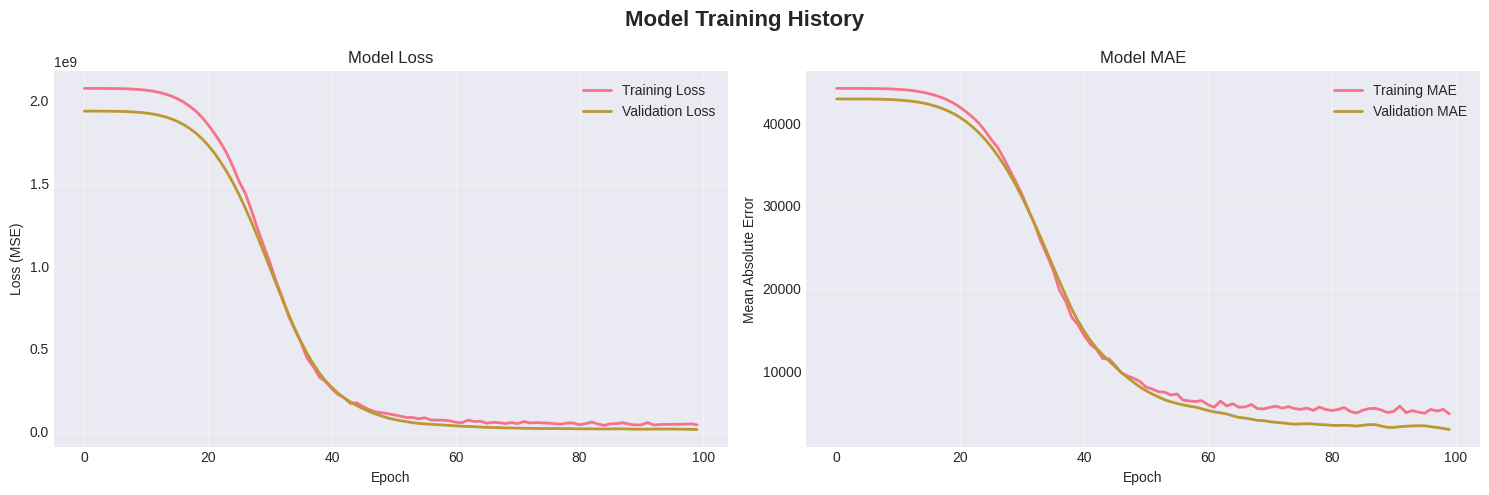


Final Metrics:
  Training Loss: 41090248.000000
  Validation Loss: 12888378.000000
  Training MAE: 4825.267578
  Validation MAE: 2927.442139


In [26]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Training History', fontsize=16, fontweight='bold')

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Model MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Metrics:")
print(f"  Training Loss: {history.history['loss'][-1]:.6f}")
print(f"  Validation Loss: {history.history['val_loss'][-1]:.6f}")
print(f"  Training MAE: {history.history['mae'][-1]:.6f}")
print(f"  Validation MAE: {history.history['val_mae'][-1]:.6f}")

## Step 7 : Model Evaluation and Predictions

In [29]:
#from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test_processed)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.3f}")

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Mean Squared Error (MSE):        ${mse:.2f}")
print(f"Root Mean Squared Error (RMSE):  ${rmse:.2f}")
print(f"Mean Absolute Error (MAE):       ${mae:.2f}")
print(f"Mean Absolute Percentage Error:  {mape:.2f}%")
print(f"R² Score:                        {r2:.4f} ({r2*100:.2f}%)")
print("="*60)

# Interpretation
print("\nInterpretation:")
if r2 > 0.9:
    print("  🟢 Excellent model performance!")
elif r2 > 0.8:
    print("  🟢 Good model performance")
elif r2 > 0.7:
    print("  🟡 Moderate model performance")
else:
    print("  🔴 Model needs improvement")

print(f"  Average prediction error: ${mae:.2f} per customer ({mape:.2f}%)")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 2760.30
R² Score: 0.897
MODEL PERFORMANCE METRICS
Mean Squared Error (MSE):        $11101375.70
Root Mean Squared Error (RMSE):  $3331.87
Mean Absolute Error (MAE):       $2760.30
Mean Absolute Percentage Error:  6.72%
R² Score:                        0.8972 (89.72%)

Interpretation:
  🟢 Good model performance
  Average prediction error: $2760.30 per customer (6.72%)


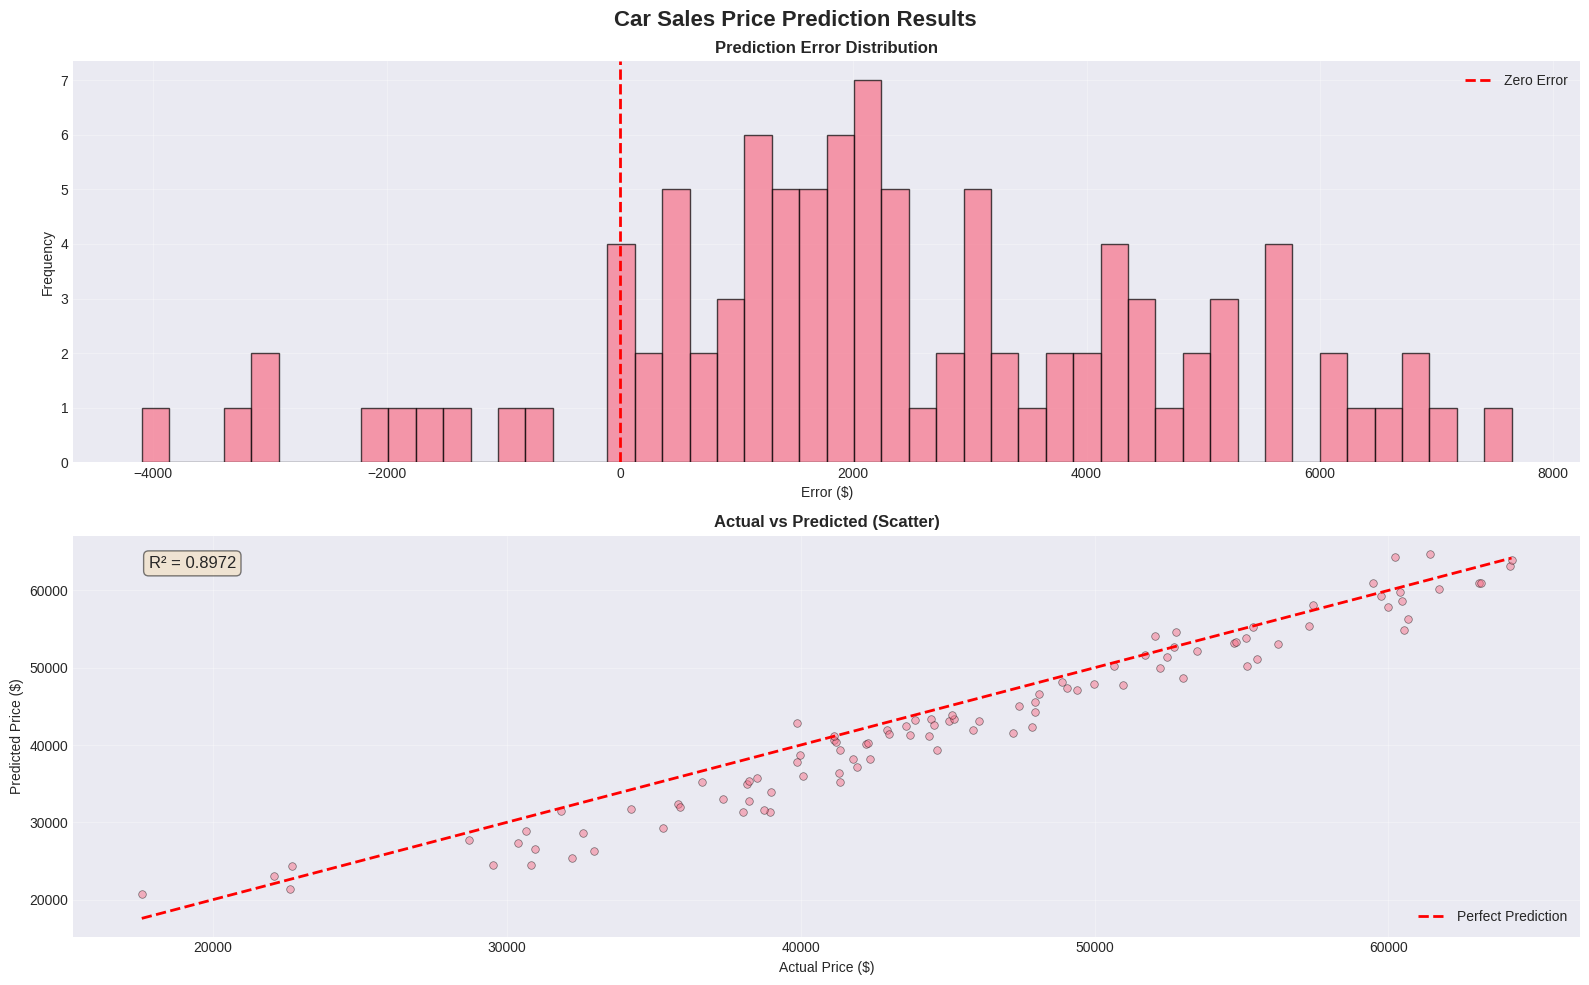

In [38]:
# Comprehensive visualization of results
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle('Car Sales Price Prediction Results', fontsize=16, fontweight='bold')

# Plot 1: Prediction Error Distribution
error = y_test - y_pred.flatten()
axes[0].hist(error, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_title('Prediction Error Distribution', fontweight='bold')
axes[0].set_xlabel('Error ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter Plot - Actual vs Predicted
axes[1].scatter(y_test, y_pred, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title('Actual vs Predicted (Scatter)', fontweight='bold')
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add R² score as text
axes[1].text(0.05, 0.95, f'R² = {r2:.4f}',
                transform=axes[1].transAxes,
                fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [39]:
# Show last 10 predictions vs actuals
print("\nLast 10 Predictions vs Actual Prices:")
print("="*60)

comparison_df = pd.DataFrame({
    'Actual Price': y_test[-10:],
    'Predicted Price': y_pred[-10:].flatten(),
    'Error': y_test[-10:] - y_pred[-10:].flatten(),
    'Error %': ((y_test[-10:] - y_pred[-10:].flatten()) / y_test[-10:] * 100)
})

comparison_df.index = range(len(comparison_df), 0, -1)
comparison_df.index.name = 'Customers'

print(comparison_df.to_string())
print("="*60)


Last 10 Predictions vs Actual Prices:
           Actual Price  Predicted Price        Error    Error %
Customers                                                       
10          29540.87013     24443.070312  5097.799817  17.256769
9           37364.23474     33056.363281  4307.871459  11.529398
8           30964.07804     26593.730469  4370.347571  14.114251
7           41137.89459     41181.273438   -43.378847  -0.105447
6           32208.37522     25432.296875  6776.078345  21.038250
5           49079.29461     47357.089844  1722.204766   3.509025
4           45167.32542     43849.289062  1318.036358   2.918119
3           50958.08115     47798.156250  3159.924900   6.201028
2           43898.27330     43300.730469   597.542831   1.361199
1           53017.26723     48706.843750  4310.423480   8.130226


## Step 8 : Save Model, Preprocessor and Features

In [40]:
import pickle

# Save ANN model
model_filename = 'car_sales_price_prediction_ann.pkl'
with open(f"{model_filename}", "wb") as f:
    pickle.dump(model, f)
print(f"✓ Model saved as: {model_filename}")

# Save X preprocessing pipeline
with open("x_preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

# Save y scaler (if used)
# with open("y_scaler.pkl", "wb") as f:
#     pickle.dump(y_scaler, f)

print(f"✓ Scalers & Encoders saved as: x_preprocessor.pkl")

# Save feature metadata
feature_metadata = {
    "numerical_features": numerical_features,
    "categorical_features": categorical_features
}

with open("feature_metadata.pkl", "wb") as f:
    pickle.dump(feature_metadata, f)

print(f"✓ Feature metadata saved as: feature_metadata.pkl")
print("\n✅ All artifacts saved successfully!")

✓ Model saved as: car_sales_price_prediction_ann.pkl
✓ Scalers & Encoders saved as: x_preprocessor.pkl
✓ Feature metadata saved as: feature_metadata.pkl

✅ All artifacts saved successfully!


## Step 9 : Model Summary and Recommendations for Improvement

In [43]:
print("="*60)
print("MODEL SUMMARY AND RECOMMENDATIONS")
print("="*60)

print(f"\n📊 Model Performance:")
print(f"   R² Score: {r2:.4f} ({r2*100:.2f}%)")
print(f"   Average Error: ${mae:.2f} ({mape:.2f}%)")

print(f"\n🎯 Training Details:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")
print(f"   Number of features: {len(numerical_features) + len(categorical_features)}")
print(f"   Epochs trained: {len(history.history['loss'])}")

print(f"\n🔄 To improve the model:")
print(f"   - Add more data")
print(f"   - Try LSTM/GRU layers for better sequence modeling")
print(f"   - Experiment with different architectures")
print(f"   - Use ensemble methods (combine multiple models)")
print(f"   - Tune hyperparameters systematically")

print("\n" + "="*60)
print("✅ ANALYSIS COMPLETE!")
print("="*60)

MODEL SUMMARY AND RECOMMENDATIONS

📊 Model Performance:
   R² Score: 0.8972 (89.72%)
   Average Error: $2760.30 (6.72%)

🎯 Training Details:
   Training samples: 400
   Test samples: 100
   Number of features: 15
   Epochs trained: 100

🔄 To improve the model:
   - Add more data
   - Try LSTM/GRU layers for better sequence modeling
   - Experiment with different architectures
   - Use ensemble methods (combine multiple models)
   - Tune hyperparameters systematically

✅ ANALYSIS COMPLETE!
